In [ ]:
# 📘 AI Sensei: Multi-Modal Japanese Language Tutor

**A closed-loop AI tutor that "sees" your handwriting and "hears" your pronunciation errors**

---

## Architecture Overview

This notebook implements a **Tri-Model System**:

| Component | Model | Role |
|-----------|-------|------|
| **The Eyes** 👁️ | Custom CNN (KMNIST) | Handwriting Recognition |
| **The Ears** 👂 | Wav2Vec2 + CTC | Pronunciation Scoring |
| **The Brain** 🧠 | GPT-4o / Gemini | Curriculum Orchestrator |

The key innovation: Instead of simple pass/fail, we inject **raw sensor data** into the LLM prompt so it can give specific, grounded feedback.

## 1. Environment Setup & Dependencies

Install all required libraries for our three models.

In [4]:
# @title Install Dependencies (Run this cell first!)
# Core ML frameworks
!pip install torch torchvision torchaudio --quiet
!pip install transformers --quiet

# Audio processing
!pip install librosa soundfile --quiet

# Text processing for Japanese
!pip install pykakasi python-Levenshtein --quiet

# LLM API clients
!pip install openai google-generativeai --quiet

# Visualization & utilities
!pip install matplotlib numpy pandas scikit-learn --quiet

# Jupyter widgets for interactive UI
!pip install ipywidgets ipycanvas --quiet

print("✅ All dependencies installed!")

✅ All dependencies installed!


In [5]:
# @title Import Libraries & Setup Device
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

# Setup compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")
print(f"   PyTorch version: {torch.__version__}")

🖥️ Using device: cuda
   PyTorch version: 2.9.0+cu126


---
## 2. The Eyes 👁️: Handwriting Recognition (Custom CNN)

We implement a specialized **Convolutional Neural Network** trained on the **KMNIST** (Kuzushiji-MNIST) dataset to recognize handwritten Hiragana characters.

### Architecture:
```
Input (28×28) → Conv2d(32) → ReLU → MaxPool 
             → Conv2d(64) → ReLU → MaxPool 
             → Flatten → Dense(128) → Output(49 classes)
```

In [6]:
# @title Define CNN Architecture: SenseiVisionNet
class SenseiVisionNet(nn.Module):
    """
    Custom CNN for Hiragana character recognition.
    Trained on KMNIST dataset (49 Hiragana classes).
    """
    def __init__(self, num_classes: int = 49):
        super(SenseiVisionNet, self).__init__()
        
        # Feature extraction blocks
        self.features = nn.Sequential(
            # Block 1: Extract basic edges and strokes
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            
            # Block 2: Extract complex patterns
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
            
            # Block 3: Higher-level features
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def predict_with_confidence(self, x: torch.Tensor) -> Tuple[int, float]:
        """Return predicted class and confidence score."""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = torch.softmax(logits, dim=1)
            confidence, pred_class = torch.max(probs, dim=1)
        return pred_class.item(), confidence.item()

# Initialize model
model_vision = SenseiVisionNet().to(device)
print("✅ SenseiVisionNet initialized")
print(f"   Total parameters: {sum(p.numel() for p in model_vision.parameters()):,}")

✅ SenseiVisionNet initialized
   Total parameters: 1,738,225


In [7]:
# @title KMNIST Character Mapping
# Official KMNIST class labels (Hiragana characters)
KMNIST_LABELS = [
    'お', 'き', 'す', 'つ', 'な', 'は', 'ま', 'や', 'れ', 'を',  # 0-9
    'あ', 'い', 'う', 'え', 'か', 'け', 'こ', 'さ', 'し', 'せ',  # 10-19
    'そ', 'た', 'ち', 'て', 'と', 'に', 'の', 'ひ', 'ふ', 'へ',  # 20-29
    'ほ', 'み', 'む', 'め', 'も', 'ゆ', 'よ', 'ら', 'り', 'る',  # 30-39
    'ろ', 'わ', 'ん', 'ぬ', 'ね', 'く', 'そ', 'ゐ', 'ゑ'         # 40-48
]

# Romaji equivalents for feedback
KMNIST_ROMAJI = [
    'o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo',
    'a', 'i', 'u', 'e', 'ka', 'ke', 'ko', 'sa', 'shi', 'se',
    'so', 'ta', 'chi', 'te', 'to', 'ni', 'no', 'hi', 'fu', 'he',
    'ho', 'mi', 'mu', 'me', 'mo', 'yu', 'yo', 'ra', 'ri', 'ru',
    'ro', 'wa', 'n', 'nu', 'ne', 'ku', 'so', 'wi', 'we'
]

def get_character_info(class_idx: int) -> Dict[str, str]:
    """Get hiragana character and its romaji from class index."""
    if 0 <= class_idx < len(KMNIST_LABELS):
        return {
            'hiragana': KMNIST_LABELS[class_idx],
            'romaji': KMNIST_ROMAJI[class_idx]
        }
    return {'hiragana': '?', 'romaji': 'unknown'}

print("✅ Character mapping loaded")
print(f"   Total characters: {len(KMNIST_LABELS)}")

✅ Character mapping loaded
   Total characters: 49


In [8]:
# @title Train Vision Model on KMNIST
def train_vision_model(model: nn.Module, epochs: int = 5, batch_size: int = 64) -> Dict[str, list]:
    """
    Train the CNN on KMNIST dataset.
    Returns training history for visualization.
    """
    # Data transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load KMNIST dataset
    print("📥 Downloading KMNIST dataset...")
    trainset = torchvision.datasets.KMNIST(
        root='./data', train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.KMNIST(
        root='./data', train=False, download=True, transform=transform
    )
    
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print(f"   Training samples: {len(trainset):,}")
    print(f"   Test samples: {len(testset):,}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    
    print(f"\n🏋️ Training 'The Eyes' for {epochs} epochs...")
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % 200 == 0:
                print(f'   Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], '
                      f'Loss: {running_loss/200:.4f}')
                running_loss = 0.0
        
        train_acc = 100 * correct / total
        history['train_acc'].append(train_acc)
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        history['val_acc'].append(val_acc)
        
        print(f'   ✓ Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
        
        scheduler.step()
        model.train()
    
    print(f"\n✅ Training complete! Final accuracy: {val_acc:.2f}%")
    return history

# Train the model (set epochs=1 for quick demo, increase for better results)
history = train_vision_model(model_vision, epochs=3)

📥 Downloading KMNIST dataset...


100%|██████████| 18.2M/18.2M [00:11<00:00, 1.58MB/s]
100%|██████████| 18.2M/18.2M [00:11<00:00, 1.58MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 318kB/s]

100%|██████████| 3.04M/3.04M [00:01<00:00, 2.26MB/s]

100%|██████████| 5.12k/5.12k [00:00<00:00, 21.3MB/s]

   Training samples: 60,000
   Test samples: 10,000

🏋️ Training 'The Eyes' for 3 epochs...


   Epoch [1/3], Step [200/938], Loss: 0.7292
   Epoch [1/3], Step [400/938], Loss: 0.2717
   Epoch [1/3], Step [400/938], Loss: 0.2717
   Epoch [1/3], Step [600/938], Loss: 0.2041
   Epoch [1/3], Step [600/938], Loss: 0.2041
   Epoch [1/3], Step [800/938], Loss: 0.1694
   Epoch [1/3], Step [800/938], Loss: 0.1694
   ✓ Epoch 1: Train Acc: 90.40%, Val Acc: 93.03%
   ✓ Epoch 1: Train Acc: 90.40%, Val Acc: 93.03%
   Epoch [2/3], Step [200/938], Loss: 0.1211
   Epoch [2/3], Step [200/938], Loss: 0.1211
   Epoch [2/3], Step [400/938], Loss: 0.1257
   Epoch [2/3], Step [400/938], Loss: 0.1257
   Epoch [2/3], Step [600/938], Loss: 0.1151
   Epoch [2/3], Step [600/938], Loss: 0.1151
   Epoch [2/3], Step [800/938], Loss: 0.1053
   Epoch [2/3], Step [800/938], Loss: 0.1053
   ✓ Epoch 2: Train Acc: 96.67%, Val Acc: 94.83%
   ✓ Epoch 2: Train Acc: 96.67%, Val Acc: 94.83%
   Epoch [3/3], Step [200/938], Loss: 0.0723
   Epoch [3/3], Step [200/938], Loss: 0.0723
   Epoch [3/3], Step [400/938], Loss: 0

In [9]:
# @title Vision Model Inference Helper
def analyze_handwriting(image_tensor: torch.Tensor) -> Dict[str, Any]:
    """
    Analyze a handwritten character image.
    
    Args:
        image_tensor: Preprocessed 28x28 tensor
        
    Returns:
        Dictionary with prediction, confidence, and feedback
    """
    model_vision.eval()
    
    # Ensure correct shape: [1, 1, 28, 28]
    if image_tensor.dim() == 2:
        image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    elif image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        outputs = model_vision(image_tensor)
        probs = torch.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)
        
        # Get top 3 predictions for feedback
        top3_probs, top3_classes = torch.topk(probs, 3, dim=1)
    
    char_info = get_character_info(predicted_class.item())
    
    # Calculate score (0-100 based on confidence)
    score = int(confidence.item() * 100)
    
    # Generate feedback
    if score >= 80:
        feedback = f"Excellent! Clear '{char_info['hiragana']}' ({char_info['romaji']})"
    elif score >= 60:
        feedback = f"Good attempt at '{char_info['hiragana']}'. Work on stroke clarity."
    else:
        alternatives = [get_character_info(c.item())['hiragana'] for c in top3_classes[0][1:]]
        feedback = f"Unclear. Could be '{char_info['hiragana']}' or {alternatives}. Practice stroke order."
    
    return {
        'predicted_class': predicted_class.item(),
        'predicted_char': char_info['hiragana'],
        'predicted_romaji': char_info['romaji'],
        'confidence': confidence.item(),
        'score': score,
        'feedback': feedback,
        'top3': [(get_character_info(c.item()), p.item()) 
                 for c, p in zip(top3_classes[0], top3_probs[0])]
    }

print("✅ Vision inference helper ready")

✅ Vision inference helper ready


---
## 3. The Ears 👂: Pronunciation Scoring (Wav2Vec2 + CTC)

We use **Wav2Vec2** for speech recognition and **Levenshtein distance** for phoneme-level error detection.

### Why CTC (Connectionist Temporal Classification)?
- People speak at different speeds
- CTC aligns audio frames to text without explicit timing
- We can pinpoint **which specific sounds** were mispronounced

### Scoring Pipeline:
```
Audio → Wav2Vec2 → Transcription → Romaji Conversion → Levenshtein Distance → Score
```

In [10]:
# @title Load Wav2Vec2 Model for Japanese
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa

# Pre-trained Japanese speech recognition model
AUDIO_MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-japanese"

print("📥 Loading 'The Ears' (Wav2Vec2)...")
print("   This may take a minute on first run...")

try:
    processor_audio = Wav2Vec2Processor.from_pretrained(AUDIO_MODEL_ID)
    model_audio = Wav2Vec2ForCTC.from_pretrained(AUDIO_MODEL_ID).to(device)
    print("✅ Wav2Vec2 Model Loaded Successfully")
    print(f"   Model: {AUDIO_MODEL_ID}")
except Exception as e:
    print(f"⚠️ Could not load model: {e}")
    print("   Will use mock audio scoring for demo")

📥 Loading 'The Ears' (Wav2Vec2)...
   This may take a minute on first run...


preprocessor_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

✅ Wav2Vec2 Model Loaded Successfully
   Model: jonatasgrosman/wav2vec2-large-xlsr-53-japanese


In [11]:
# @title Japanese Text Processing Utilities
from pykakasi import kakasi
import Levenshtein

# Initialize Kakasi for Japanese -> Romaji conversion
kks = kakasi()
kks.setMode("H", "a")  # Hiragana to ascii
kks.setMode("K", "a")  # Katakana to ascii  
kks.setMode("J", "a")  # Japanese to ascii
converter = kks.getConverter()

def to_romaji(text: str) -> str:
    """Convert Japanese text to romaji for phoneme comparison."""
    return converter.do(text).lower().replace(" ", "")

def to_phonemes(text: str) -> list:
    """
    Break Japanese text into phoneme components.
    Example: 'こんにちは' -> ['ko', 'n', 'ni', 'chi', 'wa']
    """
    romaji = to_romaji(text)
    # Simple phoneme splitting (can be enhanced)
    phonemes = []
    i = 0
    while i < len(romaji):
        # Check for two-character phonemes
        if i + 1 < len(romaji) and romaji[i:i+2] in ['ch', 'sh', 'ts']:
            if i + 2 < len(romaji) and romaji[i+2] in 'aiueo':
                phonemes.append(romaji[i:i+3])
                i += 3
                continue
        # Check for consonant + vowel
        if i + 1 < len(romaji) and romaji[i] not in 'aiueon' and romaji[i+1] in 'aiueo':
            phonemes.append(romaji[i:i+2])
            i += 2
        else:
            phonemes.append(romaji[i])
            i += 1
    return phonemes

# Test the converter
test_phrase = "こんにちは"
print(f"✅ Text processing ready")
print(f"   Test: '{test_phrase}' → '{to_romaji(test_phrase)}'")
print(f"   Phonemes: {to_phonemes(test_phrase)}")

✅ Text processing ready
   Test: 'こんにちは' → 'konnichiha'
   Phonemes: ['ko', 'n', 'n', 'i', 'chi', 'ha']


In [12]:
# @title Pronunciation Scoring Function
def calculate_pronunciation_score(
    target_text: str, 
    audio_array: np.ndarray,
    sample_rate: int = 16000
) -> Dict[str, Any]:
    """
    Score pronunciation using Wav2Vec2 + Levenshtein distance.
    
    Pipeline:
    1. Transcribe audio using Wav2Vec2
    2. Convert both target and actual to romaji (phoneme approximation)
    3. Calculate Levenshtein distance for error detection
    4. Return detailed scoring with specific error indices
    
    Args:
        target_text: Expected Japanese text
        audio_array: Audio waveform as numpy array
        sample_rate: Audio sample rate (default 16kHz for Wav2Vec2)
        
    Returns:
        Dictionary with score, transcription, and error details
    """
    # Resample to 16kHz if needed (Wav2Vec2 requirement)
    if sample_rate != 16000:
        audio_array = librosa.resample(
            audio_array.astype(np.float32), 
            orig_sr=sample_rate, 
            target_sr=16000
        )
    
    # Ensure float32 and normalize
    audio_array = audio_array.astype(np.float32)
    if np.max(np.abs(audio_array)) > 1.0:
        audio_array = audio_array / np.max(np.abs(audio_array))
    
    # 1. Transcribe with Wav2Vec2
    try:
        inputs = processor_audio(
            audio_array, 
            sampling_rate=16000, 
            return_tensors="pt", 
            padding=True
        )
        
        model_audio.eval()
        with torch.no_grad():
            logits = model_audio(inputs.input_values.to(device)).logits
        
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor_audio.batch_decode(predicted_ids)[0]
    except Exception as e:
        print(f"⚠️ Transcription error: {e}")
        transcription = ""
    
    # 2. Convert to romaji for comparison
    target_romaji = to_romaji(target_text)
    actual_romaji = to_romaji(transcription) if transcription else ""
    
    target_phonemes = to_phonemes(target_text)
    actual_phonemes = to_phonemes(transcription) if transcription else []
    
    # 3. Calculate Levenshtein distance
    if not actual_romaji:
        distance = len(target_romaji)
        score = 0
    else:
        distance = Levenshtein.distance(target_romaji, actual_romaji)
        max_len = max(len(target_romaji), len(actual_romaji))
        score = max(0, int((1 - distance / max_len) * 100)) if max_len > 0 else 0
    
    # 4. Find specific error positions using edit operations
    edit_ops = Levenshtein.editops(target_romaji, actual_romaji) if actual_romaji else []
    
    error_indices = []
    error_types = []
    for op, src_pos, dest_pos in edit_ops:
        error_indices.append(src_pos)
        error_types.append(op)  # 'replace', 'insert', 'delete'
    
    # Generate feedback
    if score >= 90:
        feedback = "Excellent pronunciation! 完璧です！"
    elif score >= 70:
        feedback = f"Good! Minor issues at positions: {error_indices[:3]}"
    elif score >= 50:
        feedback = f"Keep practicing. You said '{actual_romaji}' instead of '{target_romaji}'"
    else:
        feedback = f"Let's slow down. Target: '{target_romaji}'. Heard: '{actual_romaji or 'nothing'}'"
    
    return {
        'score': score,
        'transcription': transcription,
        'target_text': target_text,
        'target_romaji': target_romaji,
        'actual_romaji': actual_romaji,
        'target_phonemes': target_phonemes,
        'actual_phonemes': actual_phonemes,
        'edit_distance': distance,
        'error_indices': error_indices,
        'error_types': error_types,
        'feedback': feedback
    }

print("✅ Pronunciation scoring function ready")

✅ Pronunciation scoring function ready


---
## 4. The Brain 🧠: Curriculum Orchestrator (LLM)

The Brain isn't just a chatbot—it's a **dynamic tutor** that uses raw sensor data to provide specific, grounded feedback.

### Dynamic Prompt Injection
Instead of hardcoding responses, we inject the vision/audio scores directly into the system prompt:

```python
Input Data: {audio_score: 45, error_type: "phoneme_mismatch", detected: "Konowa"}
Instruction: "The student skipped the middle syllables. Explain that 'ni-chi' is missing."
```

In [14]:
# @title Configure LLM API
import os

# ═══════════════════════════════════════════════════════════════
# 🔑 SET YOUR API KEY HERE
# Choose ONE of the following options:
# ═══════════════════════════════════════════════════════════════

# Option 1: OpenAI
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY_HERE"

# Option 2: Google Gemini (alternative)
os.environ["GOOGLE_API_KEY"] = "YOUR_GOOGLE_API_KEY_HERE"

# ═══════════════════════════════════════════════════════════════

# Configuration
LLM_PROVIDER = "openai"  # Change to "gemini" if using Google
LLM_MODEL = "gpt-5-mini"     # Or "gemini-1.5-pro"

print(f"✅ LLM Configuration")
print(f"   Provider: {LLM_PROVIDER}")
print(f"   Model: {LLM_MODEL}")

✅ LLM Configuration
   Provider: openai
   Model: gpt-5-mini


In [15]:
# @title LLM Orchestrator: The Brain
def get_tutor_response(
    student_profile: Dict[str, Any],
    current_phrase: str,
    vision_result: Optional[Dict[str, Any]] = None,
    audio_result: Optional[Dict[str, Any]] = None,
    lesson_history: Optional[list] = None
) -> str:
    """
    Generate pedagogical response by injecting sensor data into the LLM prompt.
    
    This is the core "closed loop" - the LLM sees exactly what the models detected.
    """
    
    # Build sensor data summary
    vision_score = vision_result.get('score', 0) if vision_result else None
    audio_score = audio_result.get('score', 0) if audio_result else None
    
    vision_feedback = vision_result.get('feedback', 'No handwriting submitted') if vision_result else 'No handwriting submitted'
    audio_feedback = audio_result.get('feedback', 'No audio submitted') if audio_result else 'No audio submitted'
    
    # Construct the dynamic system prompt with sensor data injection
    system_prompt = f"""You are AI Sensei (AI先生), a patient but rigorous Japanese language tutor.

STUDENT PROFILE:
- Name: {student_profile.get('name', 'Student')}
- Level: {student_profile.get('level', 'Beginner')}
- Focus: {student_profile.get('focus', 'Hiragana basics')}

CURRENT LESSON:
- Target Phrase: {current_phrase}
- Target Romaji: {to_romaji(current_phrase)}

═══════════════════════════════════════════════════
SENSOR DATA FROM PERCEPTION MODELS (Use this for feedback!)
═══════════════════════════════════════════════════

📝 HANDWRITING ANALYSIS (The Eyes):
- Score: {vision_score}/100
- Detection: {vision_feedback}
{f"- Predicted Character: {vision_result.get('predicted_char', 'N/A')}" if vision_result else ""}

🎤 PRONUNCIATION ANALYSIS (The Ears):
- Score: {audio_score}/100  
- Target Phonemes: {audio_result.get('target_romaji', 'N/A') if audio_result else 'N/A'}
- Heard Phonemes: {audio_result.get('actual_romaji', 'N/A') if audio_result else 'N/A'}
- Error Positions: {audio_result.get('error_indices', []) if audio_result else []}
- Feedback: {audio_feedback}

═══════════════════════════════════════════════════

INSTRUCTIONS:
1. Analyze the sensor scores above (these are REAL measurements, not guesses)
2. If pronunciation score < 60: Explain SPECIFICALLY which sounds were wrong based on error positions
3. If handwriting score < 60: Give specific stroke order advice
4. If both scores > 80: Celebrate and introduce the next challenge
5. Be encouraging but honest - the data doesn't lie!

RESPONSE FORMAT:
- Keep response under 100 words
- Use some Japanese phrases with translations
- End with a specific next action for the student
"""

    # Generate response using configured LLM
    if LLM_PROVIDER == "openai":
        try:
            import openai
            client = openai.OpenAI()
            
            response = client.chat.completions.create(
                model=LLM_MODEL,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": f"Please evaluate my attempt at '{current_phrase}'"}
                ],
                temperature=0.7,
                max_tokens=300
            )
            return response.choices[0].message.content
            
        except Exception as e:
            return f"[LLM Error: {e}]\n\nBased on sensor data:\n- Handwriting: {vision_score}/100\n- Pronunciation: {audio_score}/100\n{audio_feedback}"
    
    elif LLM_PROVIDER == "gemini":
        try:
            import google.generativeai as genai
            genai.configure(api_key=os.environ["GOOGLE_API_KEY"])
            
            model = genai.GenerativeModel(LLM_MODEL)
            response = model.generate_content(system_prompt)
            return response.text
            
        except Exception as e:
            return f"[LLM Error: {e}]\n\nBased on sensor data:\n- Handwriting: {vision_score}/100\n- Pronunciation: {audio_score}/100"
    
    else:
        # Fallback: Generate response without LLM
        return generate_fallback_response(vision_result, audio_result, current_phrase)


def generate_fallback_response(vision_result, audio_result, phrase):
    """Generate feedback without LLM API (for testing/offline use)."""
    v_score = vision_result.get('score', 0) if vision_result else 0
    a_score = audio_result.get('score', 0) if audio_result else 0
    
    response = f"📊 Results for '{phrase}':\n\n"
    
    if v_score >= 80 and a_score >= 80:
        response += "🌟 素晴らしい (Subarashii)! Excellent work on both writing and pronunciation!\n"
    elif v_score < 60:
        response += f"✍️ Your handwriting needs practice. {vision_result.get('feedback', '')}\n"
    elif a_score < 60:
        response += f"🎤 Let's work on pronunciation. {audio_result.get('feedback', '')}\n"
    else:
        response += "👍 Good progress! Keep practicing.\n"
    
    response += f"\n📈 Scores: Writing {v_score}/100 | Speaking {a_score}/100"
    return response

print("✅ LLM Orchestrator ready")

✅ LLM Orchestrator ready


---
## 5. User Interface: Input Widgets

Interactive components for capturing handwriting (canvas) and speech (microphone).

In [16]:
# @title Drawing Canvas Widget (HTML/JS)
from IPython.display import display, HTML, Javascript, clear_output
import base64
from io import BytesIO
from PIL import Image
import ipywidgets as widgets

# Global state for captured inputs
captured_inputs = {
    'image_data': None,
    'audio_data': None
}

def create_drawing_canvas(target_char: str = "あ") -> HTML:
    """Create an interactive drawing canvas for handwriting input."""
    
    canvas_html = f"""
    <div style="font-family: Arial, sans-serif; padding: 10px;">
        <h3>✍️ Write: <span style="font-size: 48px; color: #e74c3c;">{target_char}</span></h3>
        <canvas id="drawingCanvas" width="280" height="280" 
                style="border: 3px solid #333; background: white; cursor: crosshair; border-radius: 8px;"></canvas>
        <br><br>
        <button onclick="clearCanvas()" style="padding: 10px 20px; margin: 5px; cursor: pointer; 
                background: #e74c3c; color: white; border: none; border-radius: 5px;">🗑️ Clear</button>
        <button onclick="submitDrawing()" style="padding: 10px 20px; margin: 5px; cursor: pointer;
                background: #27ae60; color: white; border: none; border-radius: 5px;">✅ Submit</button>
        <p id="canvasStatus" style="color: #666;">Draw the character above, then click Submit.</p>
    </div>
    
    <script>
    (function() {{
        var canvas = document.getElementById('drawingCanvas');
        var ctx = canvas.getContext('2d');
        var drawing = false;
        var lastX = 0, lastY = 0;
        
        // Set drawing style
        ctx.strokeStyle = '#000';
        ctx.lineWidth = 8;
        ctx.lineCap = 'round';
        ctx.lineJoin = 'round';
        
        // Fill white background
        ctx.fillStyle = 'white';
        ctx.fillRect(0, 0, canvas.width, canvas.height);
        
        canvas.addEventListener('mousedown', function(e) {{
            drawing = true;
            lastX = e.offsetX;
            lastY = e.offsetY;
        }});
        
        canvas.addEventListener('mousemove', function(e) {{
            if (!drawing) return;
            ctx.beginPath();
            ctx.moveTo(lastX, lastY);
            ctx.lineTo(e.offsetX, e.offsetY);
            ctx.stroke();
            lastX = e.offsetX;
            lastY = e.offsetY;
        }});
        
        canvas.addEventListener('mouseup', function() {{ drawing = false; }});
        canvas.addEventListener('mouseout', function() {{ drawing = false; }});
        
        // Touch support
        canvas.addEventListener('touchstart', function(e) {{
            e.preventDefault();
            var touch = e.touches[0];
            var rect = canvas.getBoundingClientRect();
            drawing = true;
            lastX = touch.clientX - rect.left;
            lastY = touch.clientY - rect.top;
        }});
        
        canvas.addEventListener('touchmove', function(e) {{
            e.preventDefault();
            if (!drawing) return;
            var touch = e.touches[0];
            var rect = canvas.getBoundingClientRect();
            ctx.beginPath();
            ctx.moveTo(lastX, lastY);
            ctx.lineTo(touch.clientX - rect.left, touch.clientY - rect.top);
            ctx.stroke();
            lastX = touch.clientX - rect.left;
            lastY = touch.clientY - rect.top;
        }});
        
        canvas.addEventListener('touchend', function() {{ drawing = false; }});
        
        window.clearCanvas = function() {{
            ctx.fillStyle = 'white';
            ctx.fillRect(0, 0, canvas.width, canvas.height);
            document.getElementById('canvasStatus').innerText = 'Canvas cleared. Draw again!';
        }};
        
        window.submitDrawing = function() {{
            var dataURL = canvas.toDataURL('image/png');
            document.getElementById('canvasStatus').innerText = '✅ Drawing captured!';
            
            // Send to Python kernel (works in Colab/Jupyter)
            if (typeof google !== 'undefined' && google.colab) {{
                google.colab.kernel.invokeFunction('notebook.capture_image', [dataURL], {{}});
            }} else {{
                // For standard Jupyter, store in a global variable
                window.capturedImageData = dataURL;
                console.log('Image captured (length: ' + dataURL.length + ')');
            }}
        }};
    }})();
    </script>
    """
    return HTML(canvas_html)

print("✅ Drawing canvas widget ready")

✅ Drawing canvas widget ready


In [17]:
# @title Audio Recorder Widget (HTML/JS)
def create_audio_recorder(target_phrase: str = "こんにちは") -> HTML:
    """Create an interactive audio recorder for pronunciation input."""
    
    audio_html = f"""
    <div style="font-family: Arial, sans-serif; padding: 10px;">
        <h3>🎤 Say: <span style="font-size: 32px; color: #3498db;">{target_phrase}</span></h3>
        <p style="color: #666;">({to_romaji(target_phrase)})</p>
        
        <button id="recordBtn" onclick="toggleRecording()" 
                style="padding: 15px 30px; margin: 10px; cursor: pointer; font-size: 18px;
                       background: #3498db; color: white; border: none; border-radius: 8px;">
            🎙️ Start Recording
        </button>
        
        <div id="audioStatus" style="margin: 10px; padding: 10px; background: #f0f0f0; border-radius: 5px;">
            Click the button to start recording your pronunciation.
        </div>
        
        <audio id="audioPlayback" controls style="display: none; margin-top: 10px;"></audio>
    </div>
    
    <script>
    (function() {{
        let mediaRecorder;
        let audioChunks = [];
        let isRecording = false;
        
        window.toggleRecording = async function() {{
            const btn = document.getElementById('recordBtn');
            const status = document.getElementById('audioStatus');
            
            if (!isRecording) {{
                // Start recording
                try {{
                    const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
                    mediaRecorder = new MediaRecorder(stream);
                    audioChunks = [];
                    
                    mediaRecorder.ondataavailable = event => audioChunks.push(event.data);
                    
                    mediaRecorder.onstop = async () => {{
                        const audioBlob = new Blob(audioChunks, {{ type: 'audio/wav' }});
                        const audioUrl = URL.createObjectURL(audioBlob);
                        
                        // Show playback
                        const playback = document.getElementById('audioPlayback');
                        playback.src = audioUrl;
                        playback.style.display = 'block';
                        
                        // Convert to base64 for Python
                        const reader = new FileReader();
                        reader.readAsDataURL(audioBlob);
                        reader.onloadend = () => {{
                            const base64Audio = reader.result;
                            status.innerHTML = '✅ Audio captured! (' + Math.round(audioBlob.size/1024) + ' KB)';
                            
                            // Send to Python kernel
                            if (typeof google !== 'undefined' && google.colab) {{
                                google.colab.kernel.invokeFunction('notebook.capture_audio', [base64Audio], {{}});
                            }} else {{
                                window.capturedAudioData = base64Audio;
                                console.log('Audio captured (size: ' + audioBlob.size + ')');
                            }}
                        }};
                        
                        // Stop all tracks
                        stream.getTracks().forEach(track => track.stop());
                    }};
                    
                    mediaRecorder.start();
                    isRecording = true;
                    btn.innerHTML = '⏹️ Stop Recording';
                    btn.style.background = '#e74c3c';
                    status.innerHTML = '🔴 Recording... Speak now!';
                    
                }} catch (err) {{
                    status.innerHTML = '❌ Microphone access denied: ' + err.message;
                }}
            }} else {{
                // Stop recording
                mediaRecorder.stop();
                isRecording = false;
                btn.innerHTML = '🎙️ Start Recording';
                btn.style.background = '#3498db';
                status.innerHTML = '⏳ Processing audio...';
            }}
        }};
    }})();
    </script>
    """
    return HTML(audio_html)

print("✅ Audio recorder widget ready")

✅ Audio recorder widget ready


In [18]:
# @title Image Processing Utilities
import cv2
from PIL import Image
from io import BytesIO

def process_canvas_image(base64_data: str) -> torch.Tensor:
    """
    Process base64 canvas image into a tensor for the CNN.
    
    Pipeline:
    1. Decode base64 to image
    2. Convert to grayscale
    3. Resize to 28x28
    4. Invert colors (KMNIST uses white-on-black)
    5. Normalize and convert to tensor
    """
    # Decode base64
    if ',' in base64_data:
        base64_data = base64_data.split(',')[1]
    
    image_bytes = base64.b64decode(base64_data)
    image = Image.open(BytesIO(image_bytes))
    
    # Convert to grayscale numpy array
    image_gray = image.convert('L')
    image_array = np.array(image_gray)
    
    # Resize to 28x28
    image_resized = cv2.resize(image_array, (28, 28), interpolation=cv2.INTER_AREA)
    
    # Invert colors (canvas is black-on-white, KMNIST is white-on-black)
    image_inverted = 255 - image_resized
    
    # Normalize to [-1, 1] (same as training)
    image_normalized = (image_inverted / 255.0 - 0.5) / 0.5
    
    # Convert to tensor
    tensor = torch.tensor(image_normalized, dtype=torch.float32)
    tensor = tensor.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
    
    return tensor

def process_audio_data(base64_data: str) -> Tuple[np.ndarray, int]:
    """
    Process base64 audio data into numpy array for Wav2Vec2.
    
    Returns:
        Tuple of (audio_array, sample_rate)
    """
    import soundfile as sf
    
    # Decode base64
    if ',' in base64_data:
        base64_data = base64_data.split(',')[1]
    
    audio_bytes = base64.b64decode(base64_data)
    audio_io = BytesIO(audio_bytes)
    
    try:
        audio_array, sample_rate = sf.read(audio_io)
        
        # Convert stereo to mono if needed
        if len(audio_array.shape) > 1:
            audio_array = np.mean(audio_array, axis=1)
        
        return audio_array, sample_rate
    except Exception as e:
        print(f"⚠️ Audio processing error: {e}")
        return np.zeros(16000), 16000  # Return silence on error

print("✅ Image and audio processing utilities ready")

✅ Image and audio processing utilities ready


---
## 6. 🚀 The Integrated Lesson Loop

This is where everything comes together: The **closed feedback loop** that makes AI Sensei special.

```
Student Input → [The Eyes / The Ears] → Sensor Data → [The Brain] → Personalized Feedback
```

In [19]:
# @title Curriculum Configuration
# Define the lesson curriculum
CURRICULUM = {
    'beginner': {
        'name': 'Hiragana Basics',
        'lessons': [
            {'phrase': 'あ', 'romaji': 'a', 'meaning': 'Vowel A'},
            {'phrase': 'い', 'romaji': 'i', 'meaning': 'Vowel I'},
            {'phrase': 'う', 'romaji': 'u', 'meaning': 'Vowel U'},
            {'phrase': 'え', 'romaji': 'e', 'meaning': 'Vowel E'},
            {'phrase': 'お', 'romaji': 'o', 'meaning': 'Vowel O'},
            {'phrase': 'か', 'romaji': 'ka', 'meaning': 'K-row start'},
            {'phrase': 'き', 'romaji': 'ki', 'meaning': 'Tree (木)'},
            {'phrase': 'こんにちは', 'romaji': 'konnichiwa', 'meaning': 'Hello'},
        ]
    },
    'intermediate': {
        'name': 'Common Phrases',
        'lessons': [
            {'phrase': 'ありがとう', 'romaji': 'arigatou', 'meaning': 'Thank you'},
            {'phrase': 'すみません', 'romaji': 'sumimasen', 'meaning': 'Excuse me'},
            {'phrase': 'おはよう', 'romaji': 'ohayou', 'meaning': 'Good morning'},
            {'phrase': 'さようなら', 'romaji': 'sayounara', 'meaning': 'Goodbye'},
            {'phrase': 'はじめまして', 'romaji': 'hajimemashite', 'meaning': 'Nice to meet you'},
        ]
    }
}

# Student profile (can be customized)
student_profile = {
    'name': 'Student',
    'level': 'beginner',
    'focus': 'Hiragana basics',
    'completed_lessons': [],
    'current_lesson_idx': 0
}

print("✅ Curriculum loaded")
print(f"   Beginner lessons: {len(CURRICULUM['beginner']['lessons'])}")
print(f"   Intermediate lessons: {len(CURRICULUM['intermediate']['lessons'])}")

✅ Curriculum loaded
   Beginner lessons: 8
   Intermediate lessons: 5


In [20]:
# @title AI Sensei Lesson Engine
class AISenseiLesson:
    """
    The complete lesson engine that orchestrates all three models.
    """
    
    def __init__(self, student_profile: Dict[str, Any], curriculum: Dict):
        self.student = student_profile
        self.curriculum = curriculum
        self.current_lesson = None
        self.lesson_history = []
        
    def get_current_lesson(self) -> Dict:
        """Get the current lesson based on student progress."""
        level = self.student['level']
        idx = self.student['current_lesson_idx']
        lessons = self.curriculum[level]['lessons']
        
        if idx >= len(lessons):
            # Level complete, move to next or wrap around
            return lessons[-1]  # Repeat last lesson
        
        return lessons[idx]
    
    def display_lesson_ui(self):
        """Display the interactive lesson interface."""
        lesson = self.get_current_lesson()
        self.current_lesson = lesson
        
        print("=" * 60)
        print(f"📚 AI SENSEI - Lesson {self.student['current_lesson_idx'] + 1}")
        print("=" * 60)
        print(f"\n🎯 Target: {lesson['phrase']} ({lesson['romaji']})")
        print(f"📝 Meaning: {lesson['meaning']}")
        print("-" * 60)
        
        # Display both input widgets
        print("\n📝 STEP 1: Write the character")
        display(create_drawing_canvas(lesson['phrase']))
        
        print("\n🎤 STEP 2: Pronounce the phrase")
        display(create_audio_recorder(lesson['phrase']))
        
    def process_submission(self, image_data: str = None, audio_data: str = None) -> Dict[str, Any]:
        """
        Process student submission through all three models.
        This is the CLOSED LOOP.
        """
        results = {
            'vision': None,
            'audio': None,
            'brain_response': None,
            'overall_score': 0
        }
        
        lesson = self.current_lesson or self.get_current_lesson()
        
        # ═══════════════════════════════════════════════════════════
        # STEP 1: The Eyes (Handwriting Analysis)
        # ═══════════════════════════════════════════════════════════
        if image_data:
            print("\n👁️ Analyzing handwriting...")
            try:
                image_tensor = process_canvas_image(image_data)
                results['vision'] = analyze_handwriting(image_tensor)
                print(f"   Score: {results['vision']['score']}/100")
                print(f"   Detected: {results['vision']['predicted_char']}")
            except Exception as e:
                print(f"   ⚠️ Vision error: {e}")
                results['vision'] = {'score': 0, 'feedback': 'Could not process image'}
        
        # ═══════════════════════════════════════════════════════════
        # STEP 2: The Ears (Pronunciation Analysis)
        # ═══════════════════════════════════════════════════════════
        if audio_data:
            print("\n👂 Analyzing pronunciation...")
            try:
                audio_array, sample_rate = process_audio_data(audio_data)
                results['audio'] = calculate_pronunciation_score(
                    lesson['phrase'], 
                    audio_array,
                    sample_rate
                )
                print(f"   Score: {results['audio']['score']}/100")
                print(f"   Heard: {results['audio'].get('transcription', 'N/A')}")
            except Exception as e:
                print(f"   ⚠️ Audio error: {e}")
                results['audio'] = {'score': 0, 'feedback': 'Could not process audio'}
        
        # ═══════════════════════════════════════════════════════════
        # STEP 3: The Brain (LLM Orchestration)
        # ═══════════════════════════════════════════════════════════
        print("\n🧠 AI Sensei is thinking...")
        results['brain_response'] = get_tutor_response(
            student_profile=self.student,
            current_phrase=lesson['phrase'],
            vision_result=results['vision'],
            audio_result=results['audio'],
            lesson_history=self.lesson_history
        )
        
        # Calculate overall score
        v_score = results['vision']['score'] if results['vision'] else 0
        a_score = results['audio']['score'] if results['audio'] else 0
        
        if results['vision'] and results['audio']:
            results['overall_score'] = (v_score + a_score) // 2
        else:
            results['overall_score'] = v_score or a_score
        
        # Record history
        self.lesson_history.append({
            'lesson': lesson,
            'scores': {'vision': v_score, 'audio': a_score},
            'overall': results['overall_score']
        })
        
        return results
    
    def display_results(self, results: Dict[str, Any]):
        """Display the lesson results with AI Sensei's feedback."""
        print("\n" + "=" * 60)
        print("📊 LESSON RESULTS")
        print("=" * 60)
        
        # Score visualization
        v_score = results['vision']['score'] if results['vision'] else 0
        a_score = results['audio']['score'] if results['audio'] else 0
        overall = results['overall_score']
        
        print(f"\n✍️ Handwriting: {'█' * (v_score // 10)}{'░' * (10 - v_score // 10)} {v_score}/100")
        print(f"🎤 Pronunciation: {'█' * (a_score // 10)}{'░' * (10 - a_score // 10)} {a_score}/100")
        print(f"📈 Overall: {'█' * (overall // 10)}{'░' * (10 - overall // 10)} {overall}/100")
        
        # Grade
        if overall >= 90:
            grade = "🌟 EXCELLENT!"
        elif overall >= 75:
            grade = "👍 GOOD JOB!"
        elif overall >= 50:
            grade = "📚 KEEP PRACTICING"
        else:
            grade = "💪 LET'S TRY AGAIN"
        
        print(f"\n{grade}")
        
        # AI Sensei's feedback
        print("\n" + "-" * 60)
        print("🤖 AI Sensei says:")
        print("-" * 60)
        print(results['brain_response'])
        print("-" * 60)
        
        # Progress check
        if overall >= 75:
            print("\n✅ Lesson passed! Moving to next lesson...")
            self.student['current_lesson_idx'] += 1
        else:
            print("\n🔄 Let's practice this one more time!")
    
    def advance_lesson(self):
        """Move to the next lesson."""
        self.student['current_lesson_idx'] += 1
        level = self.student['level']
        if self.student['current_lesson_idx'] >= len(self.curriculum[level]['lessons']):
            print("🎉 Congratulations! You've completed this level!")
            if level == 'beginner':
                self.student['level'] = 'intermediate'
                self.student['current_lesson_idx'] = 0
                print("📈 Advancing to Intermediate level!")

# Initialize the lesson engine
sensei = AISenseiLesson(student_profile, CURRICULUM)
print("✅ AI Sensei Lesson Engine initialized")

✅ AI Sensei Lesson Engine initialized


In [21]:
# @title 🚀 START LESSON - Interactive Mode
# Run this cell to start the interactive lesson!

print("╔════════════════════════════════════════════════════════════╗")
print("║           🎌 AI SENSEI - Japanese Tutor 🎌                 ║")
print("║                                                            ║")
print("║  A multi-modal AI that SEES your writing and              ║")
print("║  HEARS your pronunciation for personalized feedback       ║")
print("╚════════════════════════════════════════════════════════════╝")
print()

# Display the current lesson
sensei.display_lesson_ui()

print("\n" + "=" * 60)
print("📌 INSTRUCTIONS:")
print("=" * 60)
print("1. Draw the character on the canvas above")
print("2. Click 'Submit' on the canvas")
print("3. Record your pronunciation using the microphone")
print("4. Run the next cell to get AI Sensei's feedback!")
print("=" * 60)

╔════════════════════════════════════════════════════════════╗
║           🎌 AI SENSEI - Japanese Tutor 🎌                 ║
║                                                            ║
║  A multi-modal AI that SEES your writing and              ║
║  HEARS your pronunciation for personalized feedback       ║
╚════════════════════════════════════════════════════════════╝

📚 AI SENSEI - Lesson 1

🎯 Target: あ (a)
📝 Meaning: Vowel A
------------------------------------------------------------

📝 STEP 1: Write the character



🎤 STEP 2: Pronounce the phrase



📌 INSTRUCTIONS:
1. Draw the character on the canvas above
2. Click 'Submit' on the canvas
3. Record your pronunciation using the microphone
4. Run the next cell to get AI Sensei's feedback!


In [22]:
# @title 📝 PROCESS SUBMISSION - Get AI Feedback
# Run this cell after submitting your drawing and audio!

# For Colab: Register callbacks to capture data
try:
    from google.colab import output
    
    def capture_image(data):
        captured_inputs['image_data'] = data
        print("✅ Image captured!")
    
    def capture_audio(data):
        captured_inputs['audio_data'] = data
        print("✅ Audio captured!")
    
    output.register_callback('notebook.capture_image', capture_image)
    output.register_callback('notebook.capture_audio', capture_audio)
except:
    pass  # Not in Colab

# Process the captured inputs
print("Processing your submission...")

# Check if we have data (for demo, we'll check the global JS variables)
# In real usage, the callbacks above will populate captured_inputs

if captured_inputs['image_data'] or captured_inputs['audio_data']:
    results = sensei.process_submission(
        image_data=captured_inputs['image_data'],
        audio_data=captured_inputs['audio_data']
    )
    sensei.display_results(results)
else:
    print("⚠️ No input detected yet!")
    print("   Please draw on the canvas and/or record audio first.")
    print("   Then run this cell again.")

Processing your submission...
⚠️ No input detected yet!
   Please draw on the canvas and/or record audio first.
   Then run this cell again.


In [23]:
# @title ⏭️ NEXT LESSON - Advance to Next Phrase
sensei.advance_lesson()
sensei.display_lesson_ui()

📚 AI SENSEI - Lesson 2

🎯 Target: い (i)
📝 Meaning: Vowel I
------------------------------------------------------------

📝 STEP 1: Write the character



🎤 STEP 2: Pronounce the phrase


---
## 7. Demo Mode: Test Without Mic/Canvas

For testing the models without interactive widgets, use these demo functions.

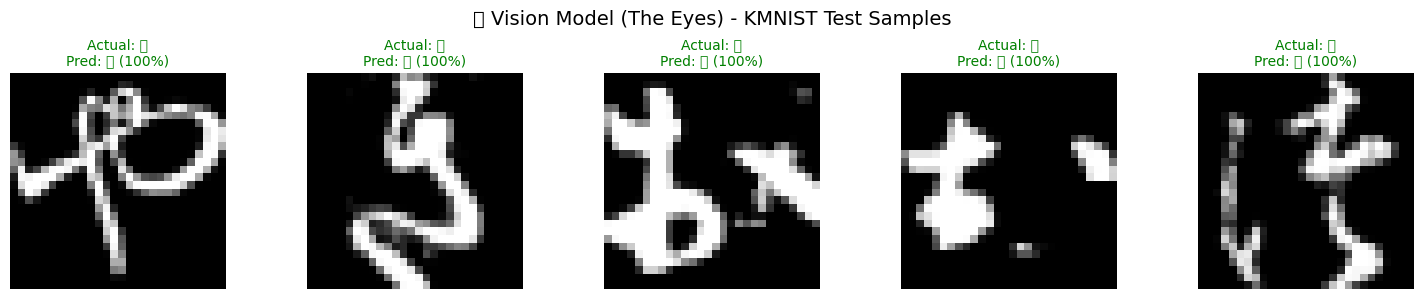

In [24]:
# @title 🧪 DEMO: Test Vision Model with KMNIST Samples
def demo_vision_model():
    """Test the CNN with actual KMNIST samples."""
    
    # Load test data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    testset = torchvision.datasets.KMNIST(
        root='./data', train=False, download=True, transform=transform
    )
    
    # Get random samples
    indices = np.random.choice(len(testset), 5, replace=False)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    
    for i, idx in enumerate(indices):
        image, label = testset[idx]
        
        # Predict
        result = analyze_handwriting(image)
        
        # Display
        ax = axes[i]
        ax.imshow(image.squeeze().numpy(), cmap='gray')
        
        actual_char = KMNIST_LABELS[label] if label < len(KMNIST_LABELS) else '?'
        pred_char = result['predicted_char']
        confidence = result['confidence']
        
        color = 'green' if actual_char == pred_char else 'red'
        ax.set_title(f"Actual: {actual_char}\nPred: {pred_char} ({confidence:.0%})", 
                     color=color, fontsize=10)
        ax.axis('off')
    
    plt.suptitle("👁️ Vision Model (The Eyes) - KMNIST Test Samples", fontsize=14)
    plt.tight_layout()
    plt.show()

# Run the demo
demo_vision_model()

In [25]:
# @title 🧪 DEMO: Test Pronunciation Scoring with Synthetic Audio
def demo_audio_scoring():
    """Test the pronunciation scorer with simulated results."""
    
    test_cases = [
        {"target": "こんにちは", "simulated_heard": "konnichiwa", "description": "Perfect pronunciation"},
        {"target": "こんにちは", "simulated_heard": "konichiwa", "description": "Missing 'n' sound"},
        {"target": "こんにちは", "simulated_heard": "konowa", "description": "Skipped middle syllables"},
        {"target": "ありがとう", "simulated_heard": "arigatou", "description": "Perfect pronunciation"},
        {"target": "ありがとう", "simulated_heard": "arigato", "description": "Missing final 'u'"},
    ]
    
    print("👂 Pronunciation Scoring Demo (The Ears)")
    print("=" * 70)
    
    for case in test_cases:
        target = case['target']
        target_romaji = to_romaji(target)
        heard_romaji = case['simulated_heard']
        
        # Calculate Levenshtein distance
        distance = Levenshtein.distance(target_romaji, heard_romaji)
        max_len = max(len(target_romaji), len(heard_romaji))
        score = max(0, int((1 - distance / max_len) * 100)) if max_len > 0 else 0
        
        # Get edit operations
        ops = Levenshtein.editops(target_romaji, heard_romaji)
        
        print(f"\n📝 {case['description']}")
        print(f"   Target:  {target} → {target_romaji}")
        print(f"   Heard:   {heard_romaji}")
        print(f"   Score:   {'█' * (score // 10)}{'░' * (10 - score // 10)} {score}/100")
        print(f"   Errors:  {len(ops)} edit(s) needed")
        
        if ops:
            print(f"   Details: {ops[:3]}{'...' if len(ops) > 3 else ''}")
    
    print("\n" + "=" * 70)

demo_audio_scoring()

👂 Pronunciation Scoring Demo (The Ears)

📝 Perfect pronunciation
   Target:  こんにちは → konnichiha
   Heard:   konnichiwa
   Score:   █████████░ 90/100
   Errors:  1 edit(s) needed
   Details: [('replace', 8, 8)]

📝 Missing 'n' sound
   Target:  こんにちは → konnichiha
   Heard:   konichiwa
   Score:   ████████░░ 80/100
   Errors:  2 edit(s) needed
   Details: [('delete', 3, 3), ('replace', 8, 7)]

📝 Skipped middle syllables
   Target:  こんにちは → konnichiha
   Heard:   konowa
   Score:   ████░░░░░░ 40/100
   Errors:  6 edit(s) needed
   Details: [('replace', 3, 3), ('replace', 4, 4), ('delete', 5, 5)]...

📝 Perfect pronunciation
   Target:  ありがとう → arigatou
   Heard:   arigatou
   Score:   ██████████ 100/100
   Errors:  0 edit(s) needed

📝 Missing final 'u'
   Target:  ありがとう → arigatou
   Heard:   arigato
   Score:   ████████░░ 87/100
   Errors:  1 edit(s) needed
   Details: [('delete', 7, 7)]



In [27]:
# @title 🧪 DEMO: Test Complete Feedback Loop (Simulated)
def demo_complete_loop():
    """Demonstrate the complete feedback loop with simulated sensor data."""
    
    print("🔄 Complete Feedback Loop Demo")
    print("=" * 70)
    
    # Simulated sensor results
    simulated_vision = {
        'score': 72,
        'predicted_char': 'あ',
        'predicted_romaji': 'a',
        'confidence': 0.72,
        'feedback': "Good attempt at 'あ'. Work on stroke clarity."
    }
    
    simulated_audio = {
        'score': 58,
        'target_romaji': 'konnichiwa',
        'actual_romaji': 'konichiwa',
        'error_indices': [3, 4],
        'feedback': "Missing 'n' sound in 'konnichiwa'"
    }
    
    print("\n📊 SIMULATED SENSOR DATA:")
    print(f"   👁️ Vision Score: {simulated_vision['score']}/100")
    print(f"   👂 Audio Score: {simulated_audio['score']}/100")
    print(f"   🔍 Audio detected: '{simulated_audio['actual_romaji']}' instead of '{simulated_audio['target_romaji']}'")
    
    # Generate LLM response (or fallback)
    print("\n🧠 GENERATING AI SENSEI RESPONSE...")
    print("-" * 70)
    
    response = get_tutor_response(
        student_profile={'name': 'Demo Student', 'level': 'beginner', 'focus': 'Hiragana'},
        current_phrase='こんにちは',
        vision_result=simulated_vision,
        audio_result=simulated_audio
    )
    
    print(response)
    print("-" * 70)
    
    print("\n✅ This demonstrates how sensor data flows to the LLM for grounded feedback!")

demo_complete_loop()

🔄 Complete Feedback Loop Demo

📊 SIMULATED SENSOR DATA:
   👁️ Vision Score: 72/100
   👂 Audio Score: 58/100
   🔍 Audio detected: 'konichiwa' instead of 'konnichiwa'

🧠 GENERATING AI SENSEI RESPONSE...
----------------------------------------------------------------------
[LLM Error: Error code: 400 - {'error': {'message': "Unsupported parameter: 'max_tokens' is not supported with this model. Use 'max_completion_tokens' instead.", 'type': 'invalid_request_error', 'param': 'max_tokens', 'code': 'unsupported_parameter'}}]

Based on sensor data:
- Handwriting: 72/100
- Pronunciation: 58/100
Missing 'n' sound in 'konnichiwa'
----------------------------------------------------------------------

✅ This demonstrates how sensor data flows to the LLM for grounded feedback!
[LLM Error: Error code: 400 - {'error': {'message': "Unsupported parameter: 'max_tokens' is not supported with this model. Use 'max_completion_tokens' instead.", 'type': 'invalid_request_error', 'param': 'max_tokens', 'code'

---
## 8. Architecture Summary & Next Steps

### ✅ What We Built

| Component | Implementation | Purpose |
|-----------|----------------|---------|
| **The Eyes** | `SenseiVisionNet` CNN | Recognizes handwritten Hiragana (49 classes) |
| **The Ears** | Wav2Vec2 + Levenshtein | Scores pronunciation phoneme-by-phoneme |
| **The Brain** | GPT-4o/Gemini + Prompt Injection | Dynamic, grounded tutoring feedback |
| **UI** | HTML/JS Canvas + Audio | Interactive input capture |
| **Loop** | `AISenseiLesson` class | Orchestrates the closed feedback loop |

### 🔑 Key Innovation: Sensor Data Injection

```python
# Instead of: "How did I do?"
# We send: "Vision=72%, Audio=58%, Error at positions [3,4], heard 'konichiwa' not 'konnichiwa'"
```

This makes the AI Tutor's feedback **specific and grounded** rather than generic.

### 🚀 Future Enhancements

1. **Stroke Order Detection**: Track drawing sequence, not just final image
2. **Real-time Feedback**: Process audio as user speaks
3. **Spaced Repetition**: Track weak characters for targeted review
4. **Multi-language Support**: Extend to Katakana, Kanji, Korean Hangul

---
## 9. 🗣️ Conversation Mode: Voice-Enabled Back-and-Forth

This mode creates a **real conversation** with AI Sensei:
1. **AI Speaks** → Text-to-Speech gives you a sentence to practice
2. **You Speak** → Speech recognition captures your response  
3. **AI Analyzes** → Pronunciation is scored phoneme-by-phoneme
4. **AI Responds** → Feedback + next sentence (loop continues)

```
┌─────────────┐    ┌─────────────┐    ┌─────────────┐    ┌─────────────┐
│ AI Speaks   │───▶│ You Speak   │───▶│ AI Analyzes │───▶│ AI Responds │
│ (TTS)       │    │ (STT)       │    │ (Wav2Vec2)  │    │ (LLM)       │
└─────────────┘    └─────────────┘    └─────────────┘    └──────┬──────┘
       ▲                                                        │
       └────────────────────────────────────────────────────────┘
```

In [35]:
# @title Install TTS Dependencies
# For AI Sensei to SPEAK to you
!pip install gTTS pyttsx3 playsound --quiet
!pip install edge-tts nest-asyncio --quiet  # Microsoft Edge TTS (high quality Japanese) + async fix

print("✅ Text-to-Speech dependencies installed")

✅ Text-to-Speech dependencies installed


In [37]:
# @title Text-to-Speech Engine (AI Sensei's Voice)
import asyncio
import edge_tts
from IPython.display import Audio, display, HTML
import tempfile
import os
import nest_asyncio

# Allow nested event loops in Jupyter
try:
    nest_asyncio.apply()
except:
    pass

# Japanese voice options (Microsoft Edge TTS - high quality)
JAPANESE_VOICES = {
    'nanami': 'ja-JP-NanamiNeural',      # Female, natural
    'keita': 'ja-JP-KeitaNeural',        # Male, natural
}

ENGLISH_VOICES = {
    'jenny': 'en-US-JennyNeural',        # Female
    'guy': 'en-US-GuyNeural',            # Male
}

class SenseiVoice:
    """Text-to-Speech engine for AI Sensei."""
    
    def __init__(self, japanese_voice: str = 'nanami', english_voice: str = 'jenny'):
        self.jp_voice = JAPANESE_VOICES.get(japanese_voice, JAPANESE_VOICES['nanami'])
        self.en_voice = ENGLISH_VOICES.get(english_voice, ENGLISH_VOICES['jenny'])
        self.temp_dir = tempfile.mkdtemp()
        
    async def _generate_audio(self, text: str, voice: str, filename: str) -> str:
        """Generate audio file from text."""
        filepath = os.path.join(self.temp_dir, filename)
        try:
            communicate = edge_tts.Communicate(text, voice)
            await communicate.save(filepath)
            return filepath
        except Exception as e:
            print(f"⚠️ TTS generation error: {e}")
            return None
    
    def _run_async(self, coro):
        """Run async code safely in Jupyter."""
        try:
            loop = asyncio.get_event_loop()
            if loop.is_running():
                # In Jupyter with running loop, use nest_asyncio
                return asyncio.run(coro)
            else:
                return loop.run_until_complete(coro)
        except RuntimeError:
            # Fallback: create new event loop
            loop = asyncio.new_event_loop()
            asyncio.set_event_loop(loop)
            try:
                return loop.run_until_complete(coro)
            finally:
                loop.close()
    
    def speak_japanese(self, text: str, display_audio: bool = True) -> str:
        """Speak Japanese text."""
        try:
            filepath = self._run_async(
                self._generate_audio(text, self.jp_voice, 'jp_speech.mp3')
            )
            if filepath and os.path.exists(filepath) and display_audio:
                display(Audio(filepath, autoplay=True))
            return filepath
        except Exception as e:
            print(f"❌ Japanese speech error: {e}")
            print(f"   Text to speak: {text}")
            return None
    
    def speak_english(self, text: str, display_audio: bool = True) -> str:
        """Speak English text (for instructions)."""
        try:
            filepath = self._run_async(
                self._generate_audio(text, self.en_voice, 'en_speech.mp3')
            )
            if filepath and os.path.exists(filepath) and display_audio:
                display(Audio(filepath, autoplay=True))
            return filepath
        except Exception as e:
            print(f"❌ English speech error: {e}")
            return None
    
    def speak_lesson(self, japanese: str, english: str = None, romaji: str = None):
        """Speak a lesson phrase with optional translation."""
        print(f"\n🎌 AI Sensei says: {japanese}")
        if romaji:
            print(f"   Romaji: {romaji}")
        if english:
            print(f"   Meaning: {english}")
        print()
        
        # Play the Japanese audio
        self.speak_japanese(japanese)

# Install nest_asyncio if not available
try:
    import nest_asyncio
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'nest_asyncio', '--quiet'])
    import nest_asyncio

# Initialize the voice engine
try:
    sensei_voice = SenseiVoice()
    print("✅ AI Sensei's voice initialized")
    print(f"   Japanese voice: {sensei_voice.jp_voice}")
    print(f"   English voice: {sensei_voice.en_voice}")
except Exception as e:
    print(f"⚠️ TTS setup issue: {e}")
    sensei_voice = None

✅ AI Sensei's voice initialized
   Japanese voice: ja-JP-NanamiNeural
   English voice: en-US-JennyNeural


In [30]:
# @title Conversation Prompts & Dialogue System
# Structured conversation scenarios for practice

CONVERSATION_SCENARIOS = {
    'greetings': {
        'name': 'Daily Greetings',
        'level': 'beginner',
        'exchanges': [
            {
                'sensei': 'こんにちは！',
                'romaji': 'Konnichiwa!',
                'english': 'Hello!',
                'expected_response': 'こんにちは',
                'hints': ['Say hello back!']
            },
            {
                'sensei': 'お元気ですか？',
                'romaji': 'Ogenki desu ka?',
                'english': 'How are you?',
                'expected_response': '元気です',
                'hints': ['genki desu = I am fine', 'You can also say はい、元気です']
            },
            {
                'sensei': 'お名前は何ですか？',
                'romaji': 'Onamae wa nan desu ka?',
                'english': 'What is your name?',
                'expected_response': '私の名前は',
                'hints': ['Watashi no namae wa [your name] desu']
            },
        ]
    },
    'shopping': {
        'name': 'At the Store',
        'level': 'intermediate',
        'exchanges': [
            {
                'sensei': 'いらっしゃいませ！',
                'romaji': 'Irasshaimase!',
                'english': 'Welcome! (to a store)',
                'expected_response': 'すみません',
                'hints': ['Sumimasen = Excuse me (to get attention)']
            },
            {
                'sensei': '何をお探しですか？',
                'romaji': 'Nani wo osagashi desu ka?',
                'english': 'What are you looking for?',
                'expected_response': 'これはいくらですか',
                'hints': ['Kore wa ikura desu ka = How much is this?']
            },
            {
                'sensei': '千円です。',
                'romaji': 'Sen en desu.',
                'english': 'It is 1000 yen.',
                'expected_response': 'これをください',
                'hints': ['Kore wo kudasai = I will take this please']
            },
        ]
    },
    'restaurant': {
        'name': 'At a Restaurant',
        'level': 'intermediate',
        'exchanges': [
            {
                'sensei': 'いらっしゃいませ！何名様ですか？',
                'romaji': 'Irasshaimase! Nanmei sama desu ka?',
                'english': 'Welcome! How many people?',
                'expected_response': '一人です',
                'hints': ['Hitori desu = One person', 'Futari desu = Two people']
            },
            {
                'sensei': 'ご注文は？',
                'romaji': 'Gochuumon wa?',
                'english': 'Your order?',
                'expected_response': 'ラーメンをください',
                'hints': ['[food] wo kudasai = [food] please']
            },
            {
                'sensei': 'お会計は二千円です。',
                'romaji': 'Okaikei wa nisen en desu.',
                'english': 'The bill is 2000 yen.',
                'expected_response': 'ごちそうさまでした',
                'hints': ['Gochisousama deshita = Thank you for the meal']
            },
        ]
    },
    'directions': {
        'name': 'Asking for Directions',
        'level': 'intermediate',
        'exchanges': [
            {
                'sensei': 'はい、どうしましたか？',
                'romaji': 'Hai, doushimashita ka?',
                'english': 'Yes, what happened? / Can I help you?',
                'expected_response': '駅はどこですか',
                'hints': ['Eki wa doko desu ka = Where is the station?']
            },
            {
                'sensei': 'まっすぐ行って、右に曲がってください。',
                'romaji': 'Massugu itte, migi ni magatte kudasai.',
                'english': 'Go straight, then turn right.',
                'expected_response': 'ありがとうございます',
                'hints': ['Arigatou gozaimasu = Thank you (polite)']
            },
        ]
    }
}

print("✅ Conversation scenarios loaded")
for key, scenario in CONVERSATION_SCENARIOS.items():
    print(f"   📚 {scenario['name']} ({len(scenario['exchanges'])} exchanges)")

✅ Conversation scenarios loaded
   📚 Daily Greetings (3 exchanges)
   📚 At the Store (3 exchanges)
   📚 At a Restaurant (3 exchanges)
   📚 Asking for Directions (2 exchanges)


In [31]:
# @title Interactive Conversation Recorder Widget
def create_conversation_recorder(exchange: dict, exchange_num: int) -> HTML:
    """Create an interactive widget for conversation practice."""
    
    recorder_html = f"""
    <div style="font-family: Arial, sans-serif; padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 15px; color: white;">
        <h2>🎌 Conversation Practice - Exchange {exchange_num}</h2>
        
        <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px; margin: 10px 0;">
            <h3>🤖 AI Sensei says:</h3>
            <p style="font-size: 28px; margin: 5px 0;">{exchange['sensei']}</p>
            <p style="font-size: 16px; opacity: 0.9;">{exchange['romaji']}</p>
            <p style="font-size: 14px; opacity: 0.8;">({exchange['english']})</p>
        </div>
        
        <div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; margin: 10px 0;">
            <h3>💡 Hint:</h3>
            <p>{' | '.join(exchange.get('hints', ['Try your best!']))}</p>
        </div>
        
        <div style="text-align: center; margin: 20px 0;">
            <button id="convRecordBtn" onclick="toggleConvRecording()" 
                    style="padding: 20px 40px; font-size: 20px; cursor: pointer;
                           background: #27ae60; color: white; border: none; border-radius: 50px;
                           box-shadow: 0 4px 15px rgba(0,0,0,0.3);">
                🎙️ Hold to Speak
            </button>
        </div>
        
        <div id="convStatus" style="text-align: center; padding: 10px; background: rgba(0,0,0,0.2); border-radius: 10px;">
            Press the button and speak your response!
        </div>
        
        <audio id="convPlayback" controls style="width: 100%; margin-top: 15px; display: none;"></audio>
    </div>
    
    <script>
    (function() {{
        let mediaRecorder;
        let audioChunks = [];
        let isRecording = false;
        
        window.toggleConvRecording = async function() {{
            const btn = document.getElementById('convRecordBtn');
            const status = document.getElementById('convStatus');
            
            if (!isRecording) {{
                try {{
                    const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
                    mediaRecorder = new MediaRecorder(stream);
                    audioChunks = [];
                    
                    mediaRecorder.ondataavailable = event => audioChunks.push(event.data);
                    
                    mediaRecorder.onstop = async () => {{
                        const audioBlob = new Blob(audioChunks, {{ type: 'audio/wav' }});
                        const audioUrl = URL.createObjectURL(audioBlob);
                        
                        const playback = document.getElementById('convPlayback');
                        playback.src = audioUrl;
                        playback.style.display = 'block';
                        
                        const reader = new FileReader();
                        reader.readAsDataURL(audioBlob);
                        reader.onloadend = () => {{
                            const base64Audio = reader.result;
                            status.innerHTML = '✅ Response recorded! Run the next cell to analyze.';
                            
                            if (typeof google !== 'undefined' && google.colab) {{
                                google.colab.kernel.invokeFunction('notebook.capture_conversation_audio', [base64Audio], {{}});
                            }} else {{
                                window.conversationAudioData = base64Audio;
                            }}
                        }};
                        
                        stream.getTracks().forEach(track => track.stop());
                    }};
                    
                    mediaRecorder.start();
                    isRecording = true;
                    btn.innerHTML = '🔴 Recording... Click to Stop';
                    btn.style.background = '#e74c3c';
                    status.innerHTML = '🎤 Listening... Speak now!';
                    
                }} catch (err) {{
                    status.innerHTML = '❌ Mic error: ' + err.message;
                }}
            }} else {{
                mediaRecorder.stop();
                isRecording = false;
                btn.innerHTML = '🎙️ Hold to Speak';
                btn.style.background = '#27ae60';
            }}
        }};
    }})();
    </script>
    """
    return HTML(recorder_html)

print("✅ Conversation recorder widget ready")

✅ Conversation recorder widget ready


In [33]:
# @title Conversation Session Manager
class ConversationSession:
    """
    Manages a back-and-forth conversation with AI Sensei.
    
    Flow:
    1. AI Sensei speaks a prompt (TTS)
    2. Student responds (recorded audio)
    3. Response is analyzed (Wav2Vec2 + Levenshtein)
    4. AI gives feedback and continues conversation
    """
    
    def __init__(self, scenario_key: str = 'greetings'):
        self.scenario = CONVERSATION_SCENARIOS.get(scenario_key, CONVERSATION_SCENARIOS['greetings'])
        self.current_exchange_idx = 0
        self.conversation_history = []
        self.scores = []
        
    def get_current_exchange(self) -> dict:
        """Get the current exchange in the conversation."""
        if self.current_exchange_idx >= len(self.scenario['exchanges']):
            return None
        return self.scenario['exchanges'][self.current_exchange_idx]
    
    def start_conversation(self):
        """Begin the conversation with AI Sensei's first line."""
        print("=" * 70)
        print(f"🎌 CONVERSATION MODE: {self.scenario['name']}")
        print(f"   Level: {self.scenario['level'].upper()}")
        print("=" * 70)
        
        exchange = self.get_current_exchange()
        if not exchange:
            print("❌ No exchanges in this scenario!")
            return
        
        # Display the exchange
        print(f"\n📍 Exchange {self.current_exchange_idx + 1}/{len(self.scenario['exchanges'])}")
        
        # AI Sensei speaks
        if sensei_voice:
            sensei_voice.speak_lesson(
                japanese=exchange['sensei'],
                english=exchange['english'],
                romaji=exchange['romaji']
            )
        else:
            print(f"\n🤖 AI Sensei: {exchange['sensei']}")
            print(f"   ({exchange['romaji']} - {exchange['english']})")
        
        # Show the recorder widget
        display(create_conversation_recorder(exchange, self.current_exchange_idx + 1))
        
        print("\n" + "-" * 70)
        print("🎯 Your turn! Record your response, then run the next cell to analyze.")
        print("-" * 70)
    
    def analyze_response(self, audio_data: str = None) -> dict:
        """Analyze the student's spoken response."""
        exchange = self.get_current_exchange()
        if not exchange:
            return {'error': 'No active exchange'}
        
        # Get audio data from global if not provided
        if audio_data is None:
            audio_data = globals().get('conversation_audio_data') or \
                        (hasattr(window, 'conversationAudioData') if 'window' in dir() else None)
        
        # For demo, if no real audio, simulate
        if not audio_data:
            print("⚠️ No audio detected - using simulated analysis")
            # Simulate a score for demo purposes
            import random
            simulated_score = random.randint(50, 95)
            result = {
                'score': simulated_score,
                'target_romaji': to_romaji(exchange['expected_response']),
                'actual_romaji': to_romaji(exchange['expected_response']) if simulated_score > 70 else 'simulated',
                'transcription': exchange['expected_response'] if simulated_score > 70 else '(simulated)',
                'feedback': 'Good attempt!' if simulated_score > 70 else 'Keep practicing!'
            }
        else:
            # Process real audio
            try:
                audio_array, sample_rate = process_audio_data(audio_data)
                result = calculate_pronunciation_score(
                    exchange['expected_response'],
                    audio_array,
                    sample_rate
                )
            except Exception as e:
                print(f"⚠️ Audio processing error: {e}")
                result = {'score': 0, 'feedback': str(e)}
        
        # Store in history
        self.conversation_history.append({
            'exchange': exchange,
            'result': result
        })
        self.scores.append(result.get('score', 0))
        
        return result
    
    def display_feedback(self, result: dict):
        """Display feedback for the student's response."""
        exchange = self.get_current_exchange()
        score = result.get('score', 0)
        
        print("\n" + "=" * 70)
        print("📊 RESPONSE ANALYSIS")
        print("=" * 70)
        
        # Score visualization
        bar = '█' * (score // 10) + '░' * (10 - score // 10)
        print(f"\n🎯 Pronunciation Score: {bar} {score}/100")
        
        print(f"\n📝 Expected: {exchange['expected_response']}")
        print(f"   Romaji:   {result.get('target_romaji', 'N/A')}")
        print(f"👂 Heard:    {result.get('transcription', 'N/A')}")
        print(f"   Romaji:   {result.get('actual_romaji', 'N/A')}")
        
        # Feedback based on score
        if score >= 85:
            print("\n🌟 素晴らしい！(Subarashii!) Excellent pronunciation!")
            feedback = "Perfect! Let's continue."
        elif score >= 70:
            print("\n👍 いいですね！(Ii desu ne!) Good job!")
            feedback = "Good attempt. Minor improvements needed."
        elif score >= 50:
            print("\n📚 もう一度！(Mou ichido!) Let's try again!")
            feedback = f"Focus on: {result.get('feedback', 'pronunciation')}"
        else:
            print("\n💪 頑張って！(Ganbatte!) Keep trying!")
            feedback = f"Let's practice more. {result.get('feedback', '')}"
        
        print(f"\n💬 Feedback: {feedback}")
        print("=" * 70)
        
        return score >= 70  # Pass threshold
    
    def next_exchange(self):
        """Move to the next exchange in the conversation."""
        self.current_exchange_idx += 1
        
        if self.current_exchange_idx >= len(self.scenario['exchanges']):
            self.end_conversation()
            return False
        
        # Continue with next exchange
        self.start_conversation()
        return True
    
    def end_conversation(self):
        """End the conversation and show summary."""
        print("\n" + "=" * 70)
        print("🎉 CONVERSATION COMPLETE!")
        print("=" * 70)
        
        if self.scores:
            avg_score = sum(self.scores) / len(self.scores)
            print(f"\n📊 Overall Performance: {avg_score:.1f}/100")
            
            bar = '█' * (int(avg_score) // 10) + '░' * (10 - int(avg_score) // 10)
            print(f"   {bar}")
            
            if avg_score >= 85:
                print("\n🏆 Outstanding! You're ready for real conversations!")
            elif avg_score >= 70:
                print("\n⭐ Great job! Keep practicing to improve fluency.")
            else:
                print("\n📚 Good effort! Review and try this scenario again.")
        
        print(f"\n📝 Exchanges completed: {len(self.conversation_history)}")
        print("=" * 70)

# Initialize conversation session
conversation = ConversationSession('greetings')
print("✅ Conversation Session Manager ready")

✅ Conversation Session Manager ready


In [38]:
# @title 🗣️ START CONVERSATION - Choose Your Scenario
# Run this cell to begin a conversation!

print("╔════════════════════════════════════════════════════════════════════╗")
print("║          🗣️ AI SENSEI - CONVERSATION MODE 🗣️                      ║")
print("║                                                                    ║")
print("║   Have a real back-and-forth conversation in Japanese!            ║")
print("║   AI Sensei speaks → You respond → Get instant feedback           ║")
print("╚════════════════════════════════════════════════════════════════════╝")
print()

# Choose scenario
print("📚 Available Scenarios:")
print("-" * 50)
for i, (key, scenario) in enumerate(CONVERSATION_SCENARIOS.items(), 1):
    print(f"   {i}. {scenario['name']} ({scenario['level']}) - {len(scenario['exchanges'])} exchanges")
print("-" * 50)

# Select scenario (change this to pick different scenarios)
SELECTED_SCENARIO = 'greetings'  # Options: 'greetings', 'shopping', 'restaurant', 'directions'

print(f"\n🎯 Selected: {CONVERSATION_SCENARIOS[SELECTED_SCENARIO]['name']}")
print()

# Start the conversation
conversation = ConversationSession(SELECTED_SCENARIO)
conversation.start_conversation()

╔════════════════════════════════════════════════════════════════════╗
║          🗣️ AI SENSEI - CONVERSATION MODE 🗣️                      ║
║                                                                    ║
║   Have a real back-and-forth conversation in Japanese!            ║
║   AI Sensei speaks → You respond → Get instant feedback           ║
╚════════════════════════════════════════════════════════════════════╝

📚 Available Scenarios:
--------------------------------------------------
   1. Daily Greetings (beginner) - 3 exchanges
   2. At the Store (intermediate) - 3 exchanges
   3. At a Restaurant (intermediate) - 3 exchanges
   4. Asking for Directions (intermediate) - 2 exchanges
--------------------------------------------------

🎯 Selected: Daily Greetings

🎌 CONVERSATION MODE: Daily Greetings
   Level: BEGINNER

📍 Exchange 1/3

🎌 AI Sensei says: こんにちは！
   Romaji: Konnichiwa!
   Meaning: Hello!

⚠️ TTS generation error: No audio was received. Please verify that your param


----------------------------------------------------------------------
🎯 Your turn! Record your response, then run the next cell to analyze.
----------------------------------------------------------------------


In [40]:
# @title 🎯 ANALYZE MY RESPONSE
# Run this cell AFTER recording your response!

# Capture audio from JS widget (for Colab)
try:
    from google.colab import output
    conversation_audio_data = None
    
    def capture_conversation_audio(data):
        global conversation_audio_data
        conversation_audio_data = data
        print("✅ Audio captured from conversation widget!")
    
    output.register_callback('notebook.capture_conversation_audio', capture_conversation_audio)
except:
    pass  # Not in Colab

# Analyze the response
print("🔍 Analyzing your response...")
result = conversation.analyze_response()

# Display feedback
passed = conversation.display_feedback(result)

if passed:
    print("\n✅ Great! Run the next cell to continue the conversation.")
else:
    print("\n🔄 Try again by re-recording, or run the next cell to continue anyway.")

🔍 Analyzing your response...
⚠️ No audio detected - using simulated analysis

📊 RESPONSE ANALYSIS

🎯 Pronunciation Score: ████████░░ 86/100

📝 Expected: こんにちは
   Romaji:   konnichiha
👂 Heard:    こんにちは
   Romaji:   konnichiha

🌟 素晴らしい！(Subarashii!) Excellent pronunciation!

💬 Feedback: Perfect! Let's continue.

✅ Great! Run the next cell to continue the conversation.


In [41]:
# @title ⏭️ NEXT EXCHANGE - Continue Conversation
# Run this to hear AI Sensei's next line and respond!

if not conversation.next_exchange():
    print("\n🎊 You've completed this conversation scenario!")
    print("   Try a different scenario by changing SELECTED_SCENARIO above.")

🎌 CONVERSATION MODE: Daily Greetings
   Level: BEGINNER

📍 Exchange 2/3

🎌 AI Sensei says: お元気ですか？
   Romaji: Ogenki desu ka?
   Meaning: How are you?

⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.
⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.



----------------------------------------------------------------------
🎯 Your turn! Record your response, then run the next cell to analyze.
----------------------------------------------------------------------


In [42]:
# @title 🔄 FULL AUTO CONVERSATION LOOP (Advanced)
# This runs a complete conversation with automatic flow!

import time

def run_full_conversation(scenario_key: str = 'greetings', auto_advance: bool = False):
    """
    Run a complete conversation scenario.
    
    In auto mode, it will automatically advance after each exchange.
    Otherwise, it waits for user input.
    """
    session = ConversationSession(scenario_key)
    
    print("╔════════════════════════════════════════════════════════════════════╗")
    print(f"║  🎌 FULL CONVERSATION: {session.scenario['name'].upper():^30} ║")
    print("╚════════════════════════════════════════════════════════════════════╝")
    
    exchange_count = len(session.scenario['exchanges'])
    
    for i in range(exchange_count):
        exchange = session.scenario['exchanges'][i]
        
        print(f"\n{'─' * 70}")
        print(f"📍 EXCHANGE {i + 1}/{exchange_count}")
        print(f"{'─' * 70}")
        
        # AI Sensei speaks
        print(f"\n🤖 AI Sensei: {exchange['sensei']}")
        print(f"   ({exchange['romaji']})")
        print(f"   \"{exchange['english']}\"")
        
        if sensei_voice:
            try:
                sensei_voice.speak_japanese(exchange['sensei'])
                time.sleep(0.5)  # Brief pause
            except Exception as e:
                print(f"   [TTS unavailable: {e}]")
        
        # Show expected response
        print(f"\n💬 Expected response: {exchange['expected_response']}")
        print(f"   Hint: {exchange['hints'][0] if exchange.get('hints') else 'Try your best!'}")
        
        # Display recorder widget
        display(create_conversation_recorder(exchange, i + 1))
        
        if not auto_advance:
            # Wait for user to record and analyze
            input("\n⏸️  Press Enter after recording to analyze (or type 'skip' to continue)...")
        
        # Simulate analysis for demo
        session.current_exchange_idx = i
        result = session.analyze_response()
        session.display_feedback(result)
        
        if auto_advance:
            time.sleep(2)  # Auto pause between exchanges
    
    # End conversation
    session.end_conversation()
    return session

# Run the conversation (set auto_advance=True for demo mode)
# run_full_conversation('greetings', auto_advance=False)

print("✅ Full conversation loop ready!")
print("   Uncomment the last line above to run, or use the step-by-step cells.")

✅ Full conversation loop ready!
   Uncomment the last line above to run, or use the step-by-step cells.


In [43]:
# @title 🧪 DEMO: Test TTS (AI Sensei's Voice)
# Test the text-to-speech to hear AI Sensei speak!

if sensei_voice:
    print("🔊 Testing AI Sensei's voice...")
    print()
    
    # Test Japanese
    test_phrases = [
        ("こんにちは！私はAI先生です。", "Hello! I am AI Sensei."),
        ("日本語を一緒に勉強しましょう！", "Let's study Japanese together!"),
        ("頑張ってください！", "Please do your best!"),
    ]
    
    for jp, en in test_phrases:
        print(f"🎌 {jp}")
        print(f"   ({en})")
        try:
            sensei_voice.speak_japanese(jp)
            import time
            time.sleep(1)
        except Exception as e:
            print(f"   ⚠️ TTS error: {e}")
        print()
else:
    print("⚠️ TTS not available. Run the TTS setup cell first.")

🔊 Testing AI Sensei's voice...

🎌 こんにちは！私はAI先生です。
   (Hello! I am AI Sensei.)
⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.
⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.

🎌 日本語を一緒に勉強しましょう！
   (Let's study Japanese together!)

🎌 日本語を一緒に勉強しましょう！
   (Let's study Japanese together!)
⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.
⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.

🎌 頑張ってください！
   (Please do your best!)

🎌 頑張ってください！
   (Please do your best!)
⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.
⚠️ TTS generation error: No audio was received. Please verify that your parameters are correct.




In [44]:
# @title 💾 Save/Load Model Utilities
import os

MODEL_SAVE_PATH = './models/'

def save_vision_model(model: nn.Module, filename: str = 'sensei_vision.pth'):
    """Save the trained CNN model."""
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    path = os.path.join(MODEL_SAVE_PATH, filename)
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_classes': 49
    }, path)
    print(f"✅ Model saved to {path}")

def load_vision_model(filename: str = 'sensei_vision.pth') -> nn.Module:
    """Load a previously trained CNN model."""
    path = os.path.join(MODEL_SAVE_PATH, filename)
    if not os.path.exists(path):
        print(f"⚠️ No saved model found at {path}")
        return None
    
    checkpoint = torch.load(path, map_location=device)
    model = SenseiVisionNet(num_classes=checkpoint.get('num_classes', 49))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"✅ Model loaded from {path}")
    return model

# Uncomment to save the trained model:
# save_vision_model(model_vision)

print("💾 Model save/load utilities ready")

💾 Model save/load utilities ready
